In [1]:
! pip install nltk

In [2]:
! pip install sklearn

In [3]:
! pip install tslearn

In [2]:
import nltk
nltk.download('vader_lexicon')

from importlib import reload
import glob
import json

import figs #this is a 'library' of utils I employed in this notebook


import tslearn
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.utils import to_time_series_dataset

import pandas as pd
import scipy
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/coder/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Upload Andersen's goodreads scores

In [3]:
with open('All_Andersens_Goodreads_scores.json') as d:
    stories_dictionary = json.load(d)

In [4]:
len(stories_dictionary.keys())

126

In [25]:
keys= list(stories_dictionary.keys())
sorted(keys)[:3]

['a cheerful temper', 'a great grief', 'a leaf from heaven']

# Create a title-to-text dictionary for Andersen

In [10]:
texts = {}
for name in glob.glob("hca-chapters/*"):
    text = open(name).read()
    better_name = name.lower().split(".")[0].split("/")[-1]
    texts[better_name]=text
    
len(texts)

126

# Word-to-score dictionary for valence

In [7]:
VAD = open("NRC-VAD-Lexicon.txt").read()
lines = VAD.split("\n")
tabs = [l.split("\t") for l in lines]
tabs = [t for t in tabs if len(t)==4]
Vadscores = {}
for tab in tabs:
    Vadscores[tab[0]]=float(tab[1])

# A dictionary of story arcs. Here we go with VAD-based, neutral-inclusive arcs

In [ ]:
%%time

titles = [t for t in texts.keys()]

Vadarcs = {}
VadHs = {}

for title in titles: 
    print(title)
    text = texts[title].lower()
    words = nltk.wordpunct_tokenize(text)
    arc = figs.sentimarc_lexicon_oov(words, Vadscores)
    #print(arc[:5])
    Vadarcs[title] = [arc]
    #Vadarcs[title].append(arc)
    h = figs.get_Hurst(arc)
    print(h)
    VadHs[title] = [h]
    VadHs[title].append(h)
    print()

In [24]:
# see one sotry length
Vadarcs["the jewish maiden"][0][:10]

[0.5, 0.5, 0.755, 0.5, 0.5, 0.92, 0.765, 0.5, 0.5, 0.5]

In [23]:
# save Vadarcs
#with open("../hca_results/VADarcs.json","w") as fp:
#    json.dump(Vadarcs, fp)

# Measruing popularity 

In [19]:
average_ratings, filtered_hs, filtered_titles = [],[],[]

for k in titles[:]:
    scores = stories_dictionary[k]
    if len(scores)==3:
        if scores[-1]>0:
            average_ratings.append(scores[1]) 
            filtered_hs.append(VadHs[k][0])
            filtered_titles.append(k)
    else: print("scores not found")

In [20]:
len(average_ratings), average_ratings[10]

(15, 2.98)

(array([1., 1., 3., 5., 0., 0., 2., 1., 0., 2.]),
 array([2.67 , 2.816, 2.962, 3.108, 3.254, 3.4  , 3.546, 3.692, 3.838,
        3.984, 4.13 ]),
 <BarContainer object of 10 artists>)

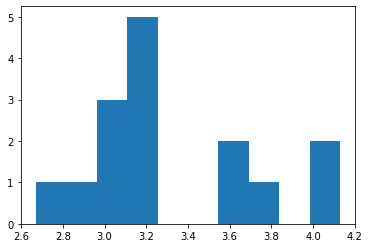

In [13]:
plt.hist(average_ratings)

In [16]:
import matplotlib.pyplot as plt

In [17]:
len(average_ratings), len(filtered_hs)

(15, 15)

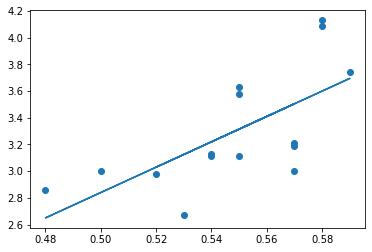

In [18]:
import numpy as np
x = np.array(filtered_hs)
y = np.array(average_ratings)
m, b = np.polyfit(x, y, 1)
plt.scatter(x,y)
plt.plot(x, m*x + b)

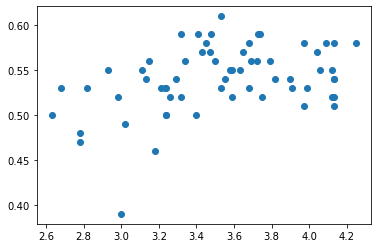

In [1117]:
plt.scatter(average_ratings, filtered_hs)

In [1118]:
np.corrcoef(x, y)

array([[1.        , 0.39804176],
       [0.39804176, 1.        ]])

In [1119]:
import scipy
pea = scipy.stats.pearsonr(x,y) 
spe = scipy.stats.spearmanr(x,y) 
ken = scipy.stats.kendalltau(x,y)
print(pea)
print(spe)
print(ken)

(0.39804176466083646, 0.0012348065857033593)
SpearmanrResult(correlation=0.3455967850690429, pvalue=0.00553380899475075)
KendalltauResult(correlation=0.23421173622513752, pvalue=0.009116931720020888)


In [1090]:
scipy.spatial.distance.correlation(x,y)

0.6019582353391636

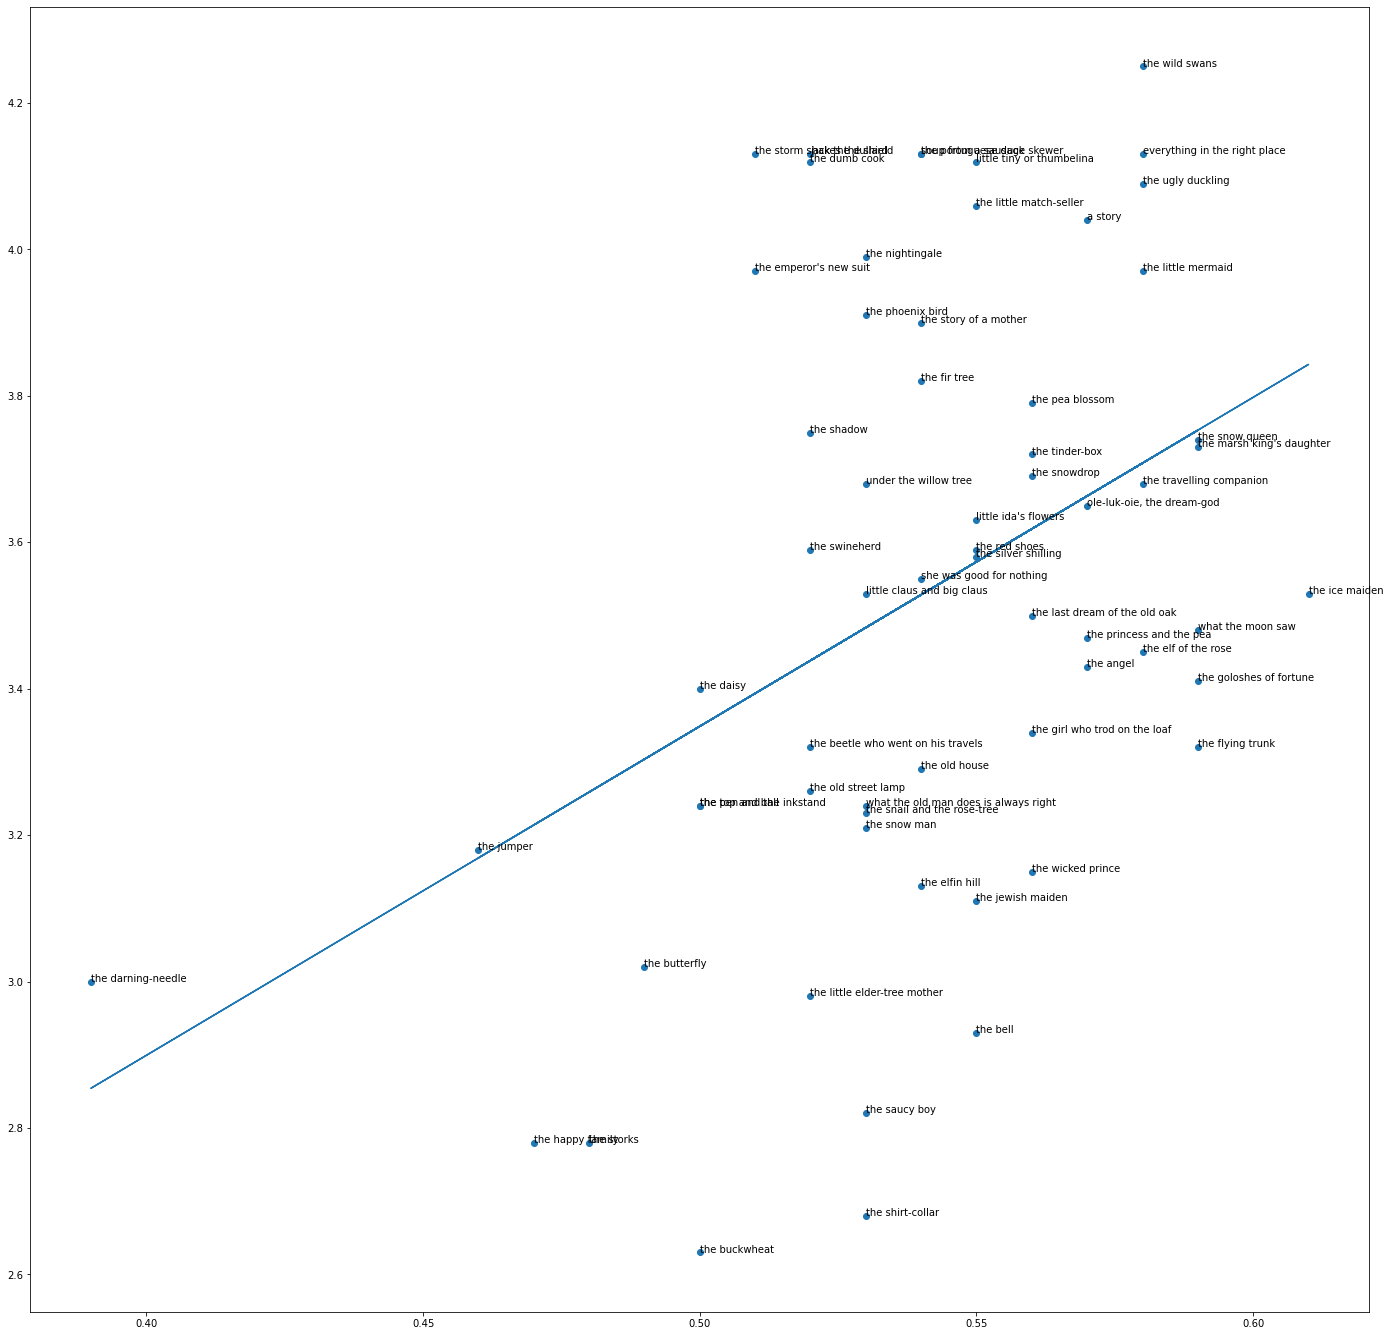

In [1089]:
annotations = filtered_titles
plt.figure(figsize=(24,24))


x = np.array(filtered_hs)
y = np.array(average_ratings)
m, b = np.polyfit(x, y, 1)
plt.scatter(x,y)
plt.plot(x, m*x + b)

for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
    
plt.show()

In [1059]:
## clustering the arcs
series = [Vadarcs[k][0] for k in Vadarcs.keys()] #[n:m]
series = [np.array(serie) for serie in series]
serialized_warcs = to_time_series_dataset(series)
resampled_warcs = TimeSeriesResampler(sz=20).fit_transform(serialized_warcs) 

labels = annotations

In [633]:
len(labels)
keys = [k for k in Vadarcs.keys()]
len(keys), len(resampled_warcs)

(126, 126)

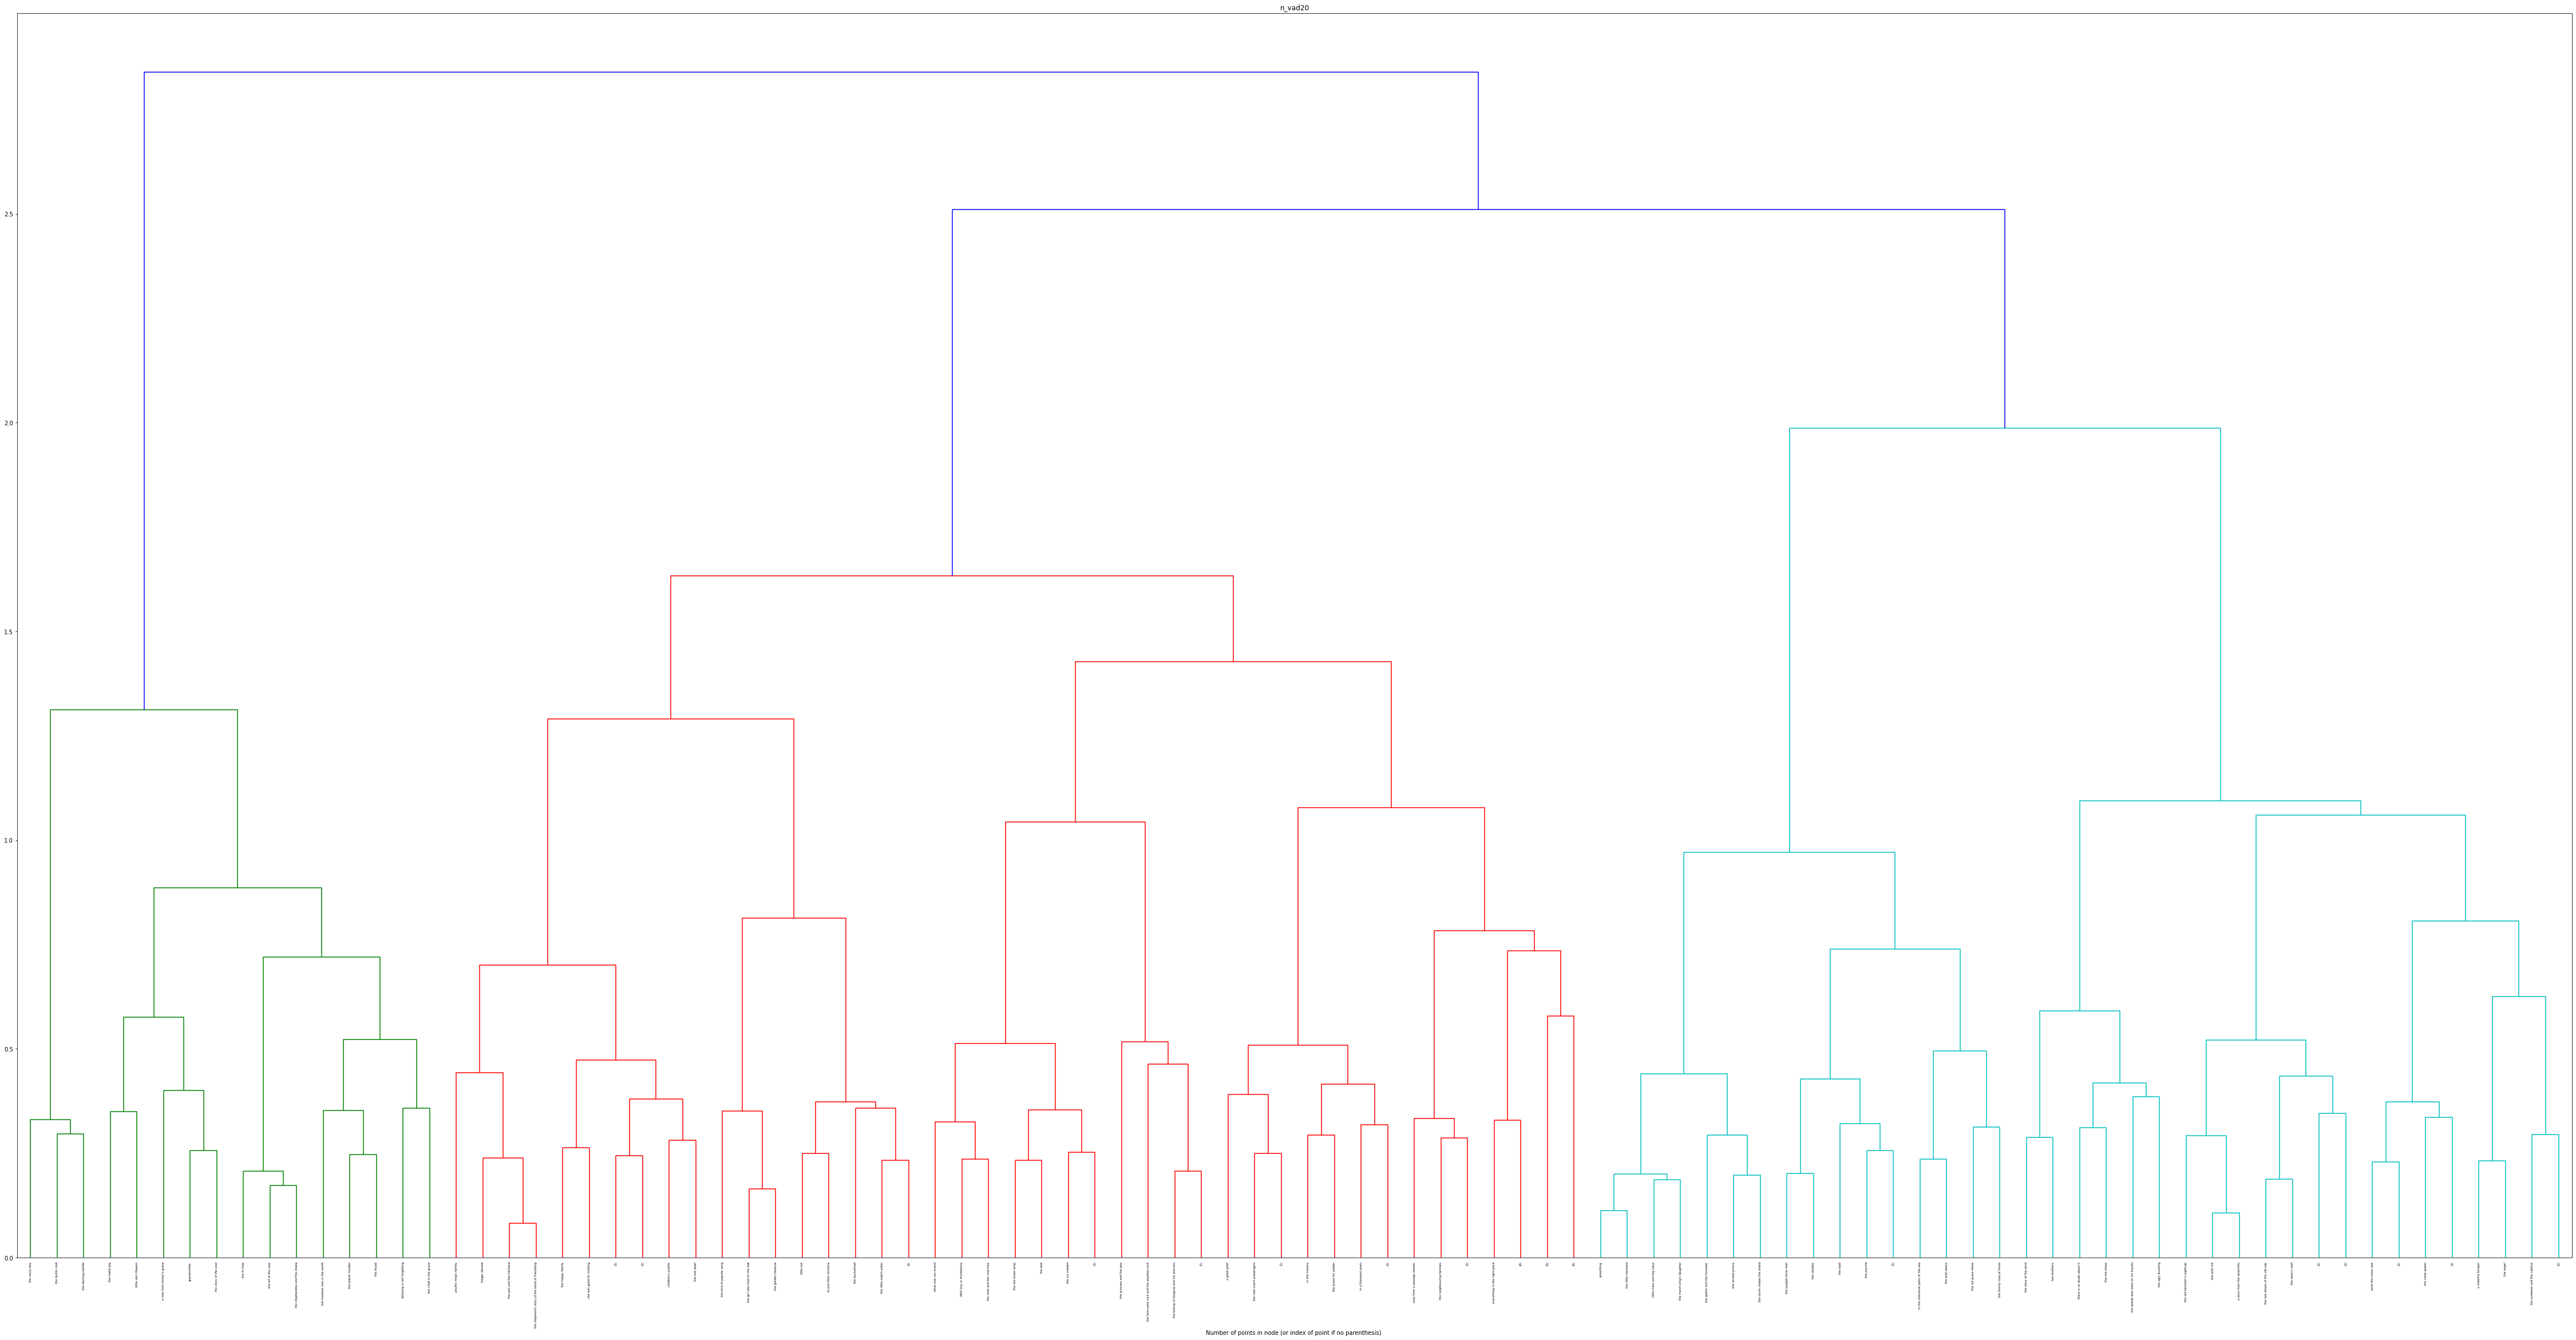

In [579]:
n=len(keys)
result = figs.plot_hierarchy_2D(resampled_warcs[:n], keys[:n], title="n_vad20", figsize=(80,40))

In [582]:
result.savefig("dendro.png")

In [634]:
from sklearn.cluster import AgglomerativeClustering
new_shape = []
for el in resampled_warcs:
    new_shape.append([float(e) for e in el])

new_shape = np.array(new_shape)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(new_shape)

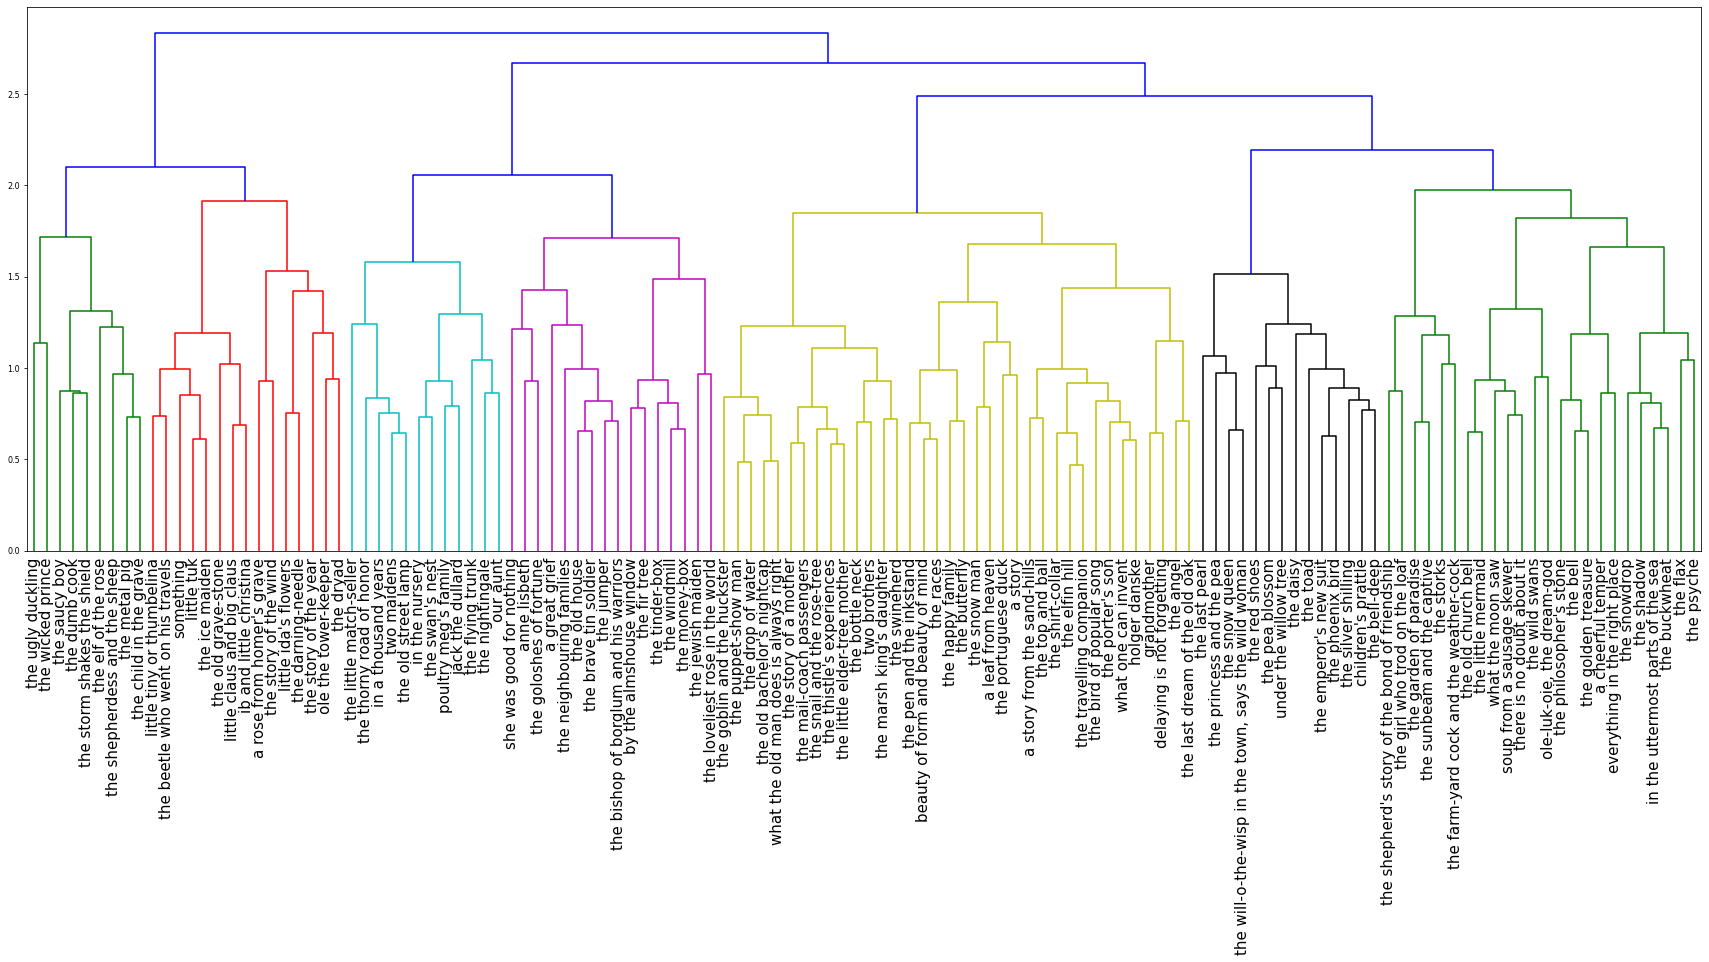

In [635]:

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1, 1, 1)


figs.plot_dendrogram(model, truncate_mode='level', ax=ax, labels=keys)

ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

fig.savefig("dendro.png")



In [731]:
model = AgglomerativeClustering(distance_threshold=None, n_clusters=3)
model = model.fit(new_shape)

labs = model.labels_

In [732]:
model.n_clusters_

3

In [733]:
ok = [(keys[i],labs[i]) for i in range(len(labs))]
ok.sort()
okdict = dict(ok)

In [734]:
okdict['the little match-seller'],okdict['the fir tree'], okdict['the tinder-box'], okdict['the brave tin soldier'], okdict['the little mermaid']

(2, 2, 2, 2, 0)

In [735]:
okdict['the ugly duckling'],okdict['little tiny or thumbelina'],okdict['the princess and the pea'],okdict['the wild swans'], okdict['jack the dullard']

(1, 1, 0, 0, 2)

In [ ]:
### Transforming it to a Panda frame to use some Seaborn's functionalities

In [38]:
matrix_lines, filtered_titles = [],[]
for k in VadHs.keys():
    scores = stories_dictionary[k]
    if len(scores)==3:
        if scores[-1]>0:
            line = []
            #average_ratings.append(scores[1])
            line += scores
            n_rat_categorical = scores[-1]>30
            line.append(n_rat_categorical)
            #filtered_hs.append(VadHs[k][-1])
            line += VadHs[k]
            matrix_lines.append(line)
            filtered_titles.append(k)
            
matrix_lines[10]

[73.0, 2.98, 62.0, True, 0.52, 0.52]

In [47]:
frame = pd.DataFrame(matrix_lines, index=filtered_titles,
                     columns=['per','avg_rat','n_rat', '>30','vadhurst','vadhurst2'])
frame

,per,avg_rat,n_rat,>30,vadhurst,vadhurst2
the metal pig,86.0,3.21,14.0,False,0.57,0.57
little ida's flowers,85.0,3.63,194.0,True,0.55,0.55
the ugly duckling,93.0,4.09,41047.0,True,0.58,0.58
the snow queen,90.0,3.74,14481.0,True,0.59,0.59
everything in the right place,95.0,4.13,11499.0,True,0.58,0.58
what one can invent,79.0,2.86,14.0,False,0.48,0.48
poultry meg's family,82.0,3.00,11.0,False,0.50,0.50
the shepherd's story of the bond of friendship,67.0,2.67,15.0,False,0.53,0.53
the last pearl,76.0,3.19,21.0,False,0.57,0.57
delaying is not forgetting,80.0,3.13,15.0,False,0.54,0.54


In [48]:
frame.columns

Index(['per', 'avg_rat', 'n_rat', '>30', 'vadhurst', 'vadhurst2'], dtype='object')

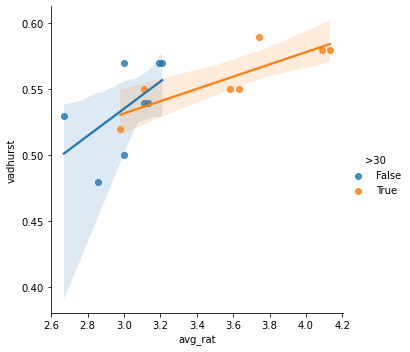

In [49]:
import seaborn as sns
sns.lmplot(x='avg_rat', y='vadhurst', hue='>30', data=frame)

In [52]:
#scipy.stats.pearsonr(frame['avg_rat'],frame['vadhurst'])

In [1019]:
cormat = frame.corr()
round(cormat,2)

,per,avg_rat,n_rat,>30,h1,h2,h3
per,1.00,0.90,0.34,0.47,0.16,0.10,0.16
avg_rat,0.90,1.00,0.48,0.62,0.16,0.12,0.19
n_rat,0.34,0.48,1.00,0.29,0.09,0.03,0.12
>30,0.47,0.62,0.29,1.00,-0.02,-0.02,-0.03
h1,0.16,0.16,0.09,-0.02,1.00,0.91,0.83
h2,0.10,0.12,0.03,-0.02,0.91,1.00,0.79
h3,0.16,0.19,0.12,-0.03,0.83,0.79,1.00


<AxesSubplot:>

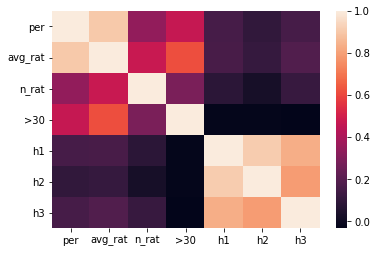

In [1020]:
sns.heatmap(cormat)

In [1092]:
frame.corr(method='spearman')

,per,avg_rat,n_rat,>30,h1,h2,h3
per,1.000000,0.914956,0.583804,0.473461,0.105386,0.079507,0.150989
avg_rat,0.914956,1.000000,0.742868,0.631611,0.129789,0.102696,0.181353
n_rat,0.583804,0.742868,1.000000,0.866045,0.031843,-0.014814,0.034234
>30,0.473461,0.631611,0.866045,1.000000,-0.026420,-0.041794,-0.026898
h1,0.105386,0.129789,0.031843,-0.026420,1.000000,0.920075,0.804568
h2,0.079507,0.102696,-0.014814,-0.041794,0.920075,1.000000,0.805865
h3,0.150989,0.181353,0.034234,-0.026898,0.804568,0.805865,1.000000
